In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import bottleneck as bn
import datetime
from numpy.lib.stride_tricks import sliding_window_view as sliding
from scipy.stats import chi2, norm
import scipy.stats as stats
import matplotlib.pyplot as plt
import scipy.optimize as opt
import cvxpy as cp
from scipy.linalg import cholesky, inv
from tqdm.auto import tqdm
import os

In [ ]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
tickers = sp500['Symbol'].tolist()
sectors = sp500.set_index('Symbol')

end_date = datetime.datetime.today()
start_date = end_date - datetime.timedelta(days=3*365+1)

data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)
adj_close = data['Close']
adj_close.dropna(how="any", axis=1, inplace=True)
adj_ret = adj_close.pct_change().iloc[1:, :]

sector_data = {}
for sector in sectors['GICS Sector'].unique():
    tickers_in_sector = sectors[sectors['GICS Sector'] == sector].index.tolist()
    tickers_in_sector = [t for t in tickers_in_sector if t in adj_ret.columns]
    sector_data[sector] = adj_ret[tickers_in_sector]


[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-05-02 15:57:43.522738 -> 2025-05-02 15:57:43.522738)')
ERROR:yfinance:['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
<ipython-input-2-c8b8f20ccc3f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_close.dropna(how="any", axis=1, inplace=True)


In [ ]:
for a, b in sector_data.items():
  print(a, b.shape[0])

Industrials 753
Health Care 753
Information Technology 753
Utilities 753
Financials 753
Materials 753
Consumer Discretionary 753
Real Estate 753
Communication Services 753
Consumer Staples 753
Energy 753


# Different settings


1. time decay functions
2. Robust Optimizers * 3
3. different penalization coefficients

# Time decay functions



In [ ]:
def equal_decay(data):
  return data

def exponential_decay(data, decay_param = 0.01) :
    T = data.shape[0]
    t = np.arange(T)[::-1]
    weights = np.exp(-decay_param * t)
    print(weights)
    weights /= weights.sum()
    return T*data * weights[:, np.newaxis]

def linear_decay(data):
    T = data.shape[0]
    t = np.arange(T)[::-1]
    weights = 1 - t / (t.max()+1)
    weights[weights < 0] = 0
    weights /= weights.sum()
    return T*data * weights[:, np.newaxis]

def sqrt_decay(data):
    T = data.shape[0]
    t = np.arange(T)[::-1]
    weights = 1 / np.sqrt(t + 1)
    weights /= weights.sum()
    return T*data * weights[:, np.newaxis]


# Optimizers

## Benchmark: Max Portfolio Sharpe Ratio s.t. sum(weights)=1

In [ ]:
# Objective function: Negative Sharpe ratio
# def benchmark(mean_vec, cov_mat, hyper_params, risk_free_rate=0.0):
#   # data can be either original data or data after applying time decay functions
#   num_assets = len(mean_vec)

#   def neg_portfolio_return(weights, mean_vec, cov_mat, risk_free_rate=0):
#     port_return = np.dot(weights, mean_vec)
#     return -port_return

#   # Constraints: Sum of weights must be 1
#   constraints = (
#       {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
#   )

#   bounds = tuple((0, 0.3) for _ in range(num_assets))

#   # Initial guess: Equal weight allocation
#   initial_weights = np.ones(num_assets) / num_assets

#   # Optimize
#   result = opt.minimize(neg_sharpe_ratio, initial_weights, args=(mean_vec, cov_mat, 0.0),
#                         method='SLSQP', bounds=bounds, constraints=constraints)

#   # Extract optimal weights and Sharpe ratio
#   optimal_weights = result.x
#   optimal_sharpe = -result.fun

#   return optimal_weights

# # def benchmark(mean_vec, cov_mat, hyper_params, risk_free_rate=0.0):
# #     num_assets = len(mean_vec)
# #     v = hyper_params.get("V", 0.02)

# #     def neg_expected_return(weights, mean_vec):
# #         return -np.dot(weights, mean_vec)

# #     cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
# #             {'type': 'ineq', 'fun': lambda x: v - np.dot(x.T, cov_mat @ x)}]

# #     bounds = tuple((0, 0.3) for _ in range(num_assets))
# #     x0 = np.ones(num_assets) / num_assets

# #     result = opt.minimize(neg_expected_return, x0,
# #                           args=(mean_vec,),
# #                           method='SLSQP',
# #                           bounds=bounds,
# #                           constraints=cons)

# #     optimal_weights = result.x
# #     optimal_return = -result.fun

# #     return optimal_weights

# def benchmark(mean_vec, cov_mat, hyper_params, risk_free_rate=0.0):
#     num_assets = len(mean_vec)
#     target_ret = hyper_params.get("target_return", 0.01)  # minimum required return

#     def portfolio_variance(weights, cov_mat):
#         return weights.T @ cov_mat @ weights

#     cons = [
#         {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
#         {'type': 'ineq', 'fun': lambda x: np.dot(x, mean_vec) - target_ret}
#     ]

#     # bounds = tuple((0, 0.3) for _ in range(num_assets))
#     x0 = np.ones(num_assets) / num_assets

#     result = opt.minimize(portfolio_variance, x0,
#                           args=(cov_mat,),
#                           method='SLSQP',
#                           # bounds=bounds,
#                           constraints=cons)

#     optimal_weights = result.x
#     optimal_variance = result.fun

#     return optimal_weights

def benchmark(mean_vec, cov_mat, hyper_params, risk_free_rate=0.0):
  num_assets = len(mean_vec)

  def neg_sharpe_ratio(weights, mean_vec, cov_mat, risk_free_rate):
      port_return = np.dot(weights, mean_vec)
      port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
      sharpe_ratio = (port_return - risk_free_rate) / port_volatility
      return -sharpe_ratio

  cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
  bounds = [(0, 1) for _ in range(num_assets)]
  x0 = np.ones(num_assets) / num_assets

  result = opt.minimize(neg_sharpe_ratio, x0, args=(mean_vec, cov_mat, risk_free_rate),
                          method='SLSQP', bounds=bounds, constraints=cons)
  return result.x

## Robust Error minimization I

In [ ]:
# def robust_opt_one_1(mean_vec, cov_mat, hyper_params, risk_free_rate=0.0):
#     num_assets = len(mean_vec)
#     kappa = hyper_params.get("kappa", 1.0)
#     v = hyper_params.get("variance_cap", 0.02)

#     def objective(weights, mean_vec, cov_mat, kappa):
#       def estimation_risk_1(x):
#         return kappa * np.sqrt(x.T @ cov_mat @ x)

#       estimation_risk1 = estimation_risk_1(weights)
#       return -(np.dot(mean_vec, weights) - estimation_risk1)

#     cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
#             {'type': 'ineq', 'fun': lambda x: v - np.dot(x.T, cov_mat @ x)}]

#     # bounds = tuple((0, 0.3) for _ in range(num_assets))
#     x0 = np.ones(num_assets) / num_assets

#     result = opt.minimize(objective, x0,
#                           args=(mean_vec, cov_mat, kappa),
#                           method='SLSQP',
#                           # bounds=bounds,
#                           constraints=cons)

#     optimal_weights = result.x
#     return optimal_weights

# def robust_opt_one(mean_vec, cov_mat, hyper_params):
#     num_assets = len(mean_vec)
#     kappa = hyper_params.get("kappa", 1.0)
#     target_return = hyper_params.get("target_return", 0.01)  # r in the constraint

#     def objective(x, cov_mat):
#         return x.T @ cov_mat @ x

#     def constraint_return_risk(x, mean_vec, cov_mat, kappa, r):
#         estimation_risk = kappa * np.sqrt(x.T @ cov_mat @ x)
#         return np.dot(mean_vec, x) - estimation_risk - r

#     cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
#             {'type': 'ineq', 'fun': lambda x: constraint_return_risk(x, mean_vec, cov_mat, kappa, target_return)}]

#     x0 = np.ones(num_assets) / num_assets

#     result = opt.minimize(objective, x0,
#                           args=(cov_mat,),
#                           method='SLSQP',
#                           constraints=cons)

#     print(result.success)

#     return result.x

def robust_opt_one(mean_vec, cov_mat, hyper_params, risk_free_rate=0.0):
  num_assets = len(mean_vec)
  kappa = hyper_params.get("kappa", 1.0)

  def neg_sharpe_ratio_robust(weights, mean_vec, cov_mat, risk_free_rate, kappa):
    def estimation_risk_1(x, mean_vec, cov_mat, kappa):
      return kappa * np.sqrt(x.T @ cov_mat @ x)

    penalty = estimation_risk_1(weights, mean_vec, cov_mat, kappa)

    port_return = np.dot(weights, mean_vec)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
    sharpe_ratio = (port_return - risk_free_rate) / port_volatility
    return -sharpe_ratio + penalty

  cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
  bounds = [(0, 1) for _ in range(num_assets)]
  x0 = np.ones(num_assets) / num_assets

  result = opt.minimize(neg_sharpe_ratio_robust, x0, args=(mean_vec, cov_mat, risk_free_rate, kappa),
                          method='SLSQP', bounds=bounds, constraints=cons)
  return result.x

## Robust Error Minimization II

In [ ]:
# def robust_opt_two(mean_vec, cov_mat, hyper_params, risk_free_rate=0.0):
#     num_assets = len(mean_vec)
#     kappa = hyper_params.get("kappa", 1.0)
#     v = hyper_params.get("V", 0.02)

#     def objective(weights, mean_vec, cov_mat, kappa):
#         e = np.ones((cov_mat.shape[0], 1))
#         D = np.eye(cov_mat.shape[0])
#         denom = (e.T @ D @ cov_mat @ D.T @ e)[0, 0]
#         middle = cov_mat - (1 / denom) * (cov_mat @ D.T @ e @ e.T @ D @ cov_mat)
#         penalty = np.sqrt(weights.T @ middle @ weights)
#         return -(np.dot(mean_vec, weights) - kappa * penalty)

#     cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
#             {'type': 'ineq', 'fun': lambda x: v - np.dot(x.T, cov_mat @ x)}]

#     # bounds = tuple((0, 0.3) for _ in range(num_assets))
#     x0 = np.ones(num_assets) / num_assets

#     result = opt.minimize(objective, x0,
#                           args=(mean_vec, cov_mat, kappa),
#                           method='SLSQP',
#                           # bounds=bounds,
#                           constraints=cons)

#     optimal_weights = result.x
#     return optimal_weights

# def robust_opt_two(mean_vec, cov_mat, hyper_params):
#     num_assets = len(mean_vec)
#     kappa = hyper_params.get("kappa", 1.0)
#     target_return = hyper_params.get("target_return", 0.01)

#     def objective(x, cov_mat):
#         return x.T @ cov_mat @ x

#     def constraint_robust_return(x, mean_vec, cov_mat, kappa, r):
#         e = np.ones((cov_mat.shape[0], 1))
#         D = np.eye(cov_mat.shape[0])
#         denom = (e.T @ D @ cov_mat @ D.T @ e)[0, 0]
#         adjustment = (1 / denom) * (cov_mat @ D.T @ e @ e.T @ D @ cov_mat)
#         adjusted_cov = cov_mat - adjustment
#         # print(x.T @ adjusted_cov @ x)
#         penalty = np.sqrt(max((x.T @ adjusted_cov @ x).item(), 1e-12))
#         return np.dot(mean_vec, x) - kappa * penalty - r

#     cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
#             {'type': 'ineq', 'fun': lambda x: constraint_robust_return(x, mean_vec, cov_mat, kappa, target_return)}]

#     x0 = np.ones(num_assets) / num_assets

#     result = opt.minimize(objective, x0,
#                           args=(cov_mat,),
#                           method='SLSQP',
#                           constraints=cons)

#     return result.x

def robust_opt_two(mean_vec, cov_mat, hyper_params, risk_free_rate=0.0):
  num_assets = len(mean_vec)
  kappa = hyper_params.get("kappa", 1.0)

  def neg_sharpe_ratio_robust(weights, mean_vec, cov_mat, risk_free_rate, kappa):
    def estimation_risk_2(x, mean_vec, cov_mat, kappa):
        e = np.ones((cov_mat.shape[0], 1))
        D = np.eye(cov_mat.shape[0])
        denom = (e.T @ D @ cov_mat @ D.T @ e)[0, 0]
        adjustment = (1 / denom) * (cov_mat @ D.T @ e @ e.T @ D @ cov_mat)
        adjusted_cov = cov_mat - adjustment
        # print(x.T @ adjusted_cov @ x)
        penalty = np.sqrt(max((x.T @ adjusted_cov @ x).item(), 1e-12))
        return kappa * penalty

    penalty = estimation_risk_2(weights, mean_vec, cov_mat, kappa)

    port_return = np.dot(weights, mean_vec)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
    sharpe_ratio = (port_return - risk_free_rate) / port_volatility
    return -sharpe_ratio + penalty

  cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
  bounds = [(0, 1) for _ in range(num_assets)]
  x0 = np.ones(num_assets) / num_assets

  result = opt.minimize(neg_sharpe_ratio_robust, x0, args=(mean_vec, cov_mat, risk_free_rate, kappa),
                          method='SLSQP', bounds=bounds, constraints=cons)
  return result.x

## Robust Optimization III




In [ ]:
# def robust_opt_three_1(mean_vec, cov_mat,hyper_params, risk_free_rate=0.0):
#     num_assets = len(mean_vec)
#     kappa = hyper_params.get("kappa", 1.0)
#     v = hyper_params.get("V", 0.02)
#     # print(cov_mat)
#     L = cholesky(cov_mat, lower=True)
#     # print(L)
#     D = inv(L)

#     def objective(weights, mean_vec, cov_mat, kappa, D):
#         e = np.ones((cov_mat.shape[0], 1))
#         denom = (e.T @ D @ cov_mat @ D.T @ e)[0, 0]
#         middle = cov_mat - (1 / denom) * (cov_mat @ D.T @ e @ e.T @ D @ cov_mat)
#         penalty = np.sqrt(weights.T @ middle @ weights)
#         return -(np.dot(mean_vec, weights) - kappa * penalty)

#     cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
#             {'type': 'ineq', 'fun': lambda x: v - np.dot(x.T, cov_mat @ x)}]

#     # bounds = tuple((0, 1) for _ in range(num_assets))
#     x0 = np.ones(num_assets) / num_assets

#     result = opt.minimize(objective, x0,
#                           args=(mean_vec, cov_mat, kappa, D),
#                           method='SLSQP',
#                           # bounds=bounds,
#                           constraints=cons)

#     optimal_weights = result.x
#     return optimal_weights

# def robust_opt_three(mean_vec, cov_mat, hyper_params):
#     num_assets = len(mean_vec)
#     kappa = hyper_params.get("kappa", 1.0)
#     target_return = hyper_params.get("target_return", 0.01)

#     L = cholesky(cov_mat, lower=True)
#     D = inv(L)

#     def objective(x, cov_mat):
#         return x.T @ cov_mat @ x

#     def constraint_robust_return(x, mean_vec, cov_mat, kappa, D, r):
#         e = np.ones((cov_mat.shape[0], 1))
#         denom = (e.T @ D @ cov_mat @ D.T @ e)[0, 0]
#         middle = cov_mat - (1 / denom) * (cov_mat @ D.T @ e @ e.T @ D @ cov_mat)
#         penalty = np.sqrt(x.T @ middle @ x)
#         return np.dot(mean_vec, x) - kappa * penalty - r

#     cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
#             {'type': 'ineq', 'fun': lambda x: constraint_robust_return(x, mean_vec, cov_mat, kappa, D, target_return)}]

#     x0 = np.ones(num_assets) / num_assets

#     result = opt.minimize(objective, x0,
#                           args=(cov_mat,),
#                           method='SLSQP',
#                           constraints=cons)

#     return result.x

def robust_opt_three(mean_vec, cov_mat, hyper_params, risk_free_rate=0.0):
  num_assets = len(mean_vec)
  kappa = hyper_params.get("kappa", 1.0)

  def neg_sharpe_ratio_robust(weights, mean_vec, cov_mat, risk_free_rate, kappa):
    def estimation_risk_3(x, mean_vec, cov_mat, kappa):
        L = cholesky(cov_mat, lower=True)
        D = inv(L)
        e = np.ones((cov_mat.shape[0], 1))
        denom = (e.T @ D @ cov_mat @ D.T @ e)[0, 0]
        adjustment = (1 / denom) * (cov_mat @ D.T @ e @ e.T @ D @ cov_mat)
        adjusted_cov = cov_mat - adjustment
        # print(x.T @ adjusted_cov @ x)
        penalty = np.sqrt(max((x.T @ adjusted_cov @ x).item(), 1e-12))
        return kappa * penalty

    penalty = estimation_risk_3(weights, mean_vec, cov_mat, kappa)

    port_return = np.dot(weights, mean_vec)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
    sharpe_ratio = (port_return - risk_free_rate) / port_volatility
    return -sharpe_ratio+penalty

  cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
  bounds = [(0, 1) for _ in range(num_assets)]
  x0 = np.ones(num_assets) / num_assets

  result = opt.minimize(neg_sharpe_ratio_robust, x0, args=(mean_vec, cov_mat, risk_free_rate, kappa),
                          method='SLSQP', bounds = bounds, constraints=cons)
  return result.x

# Generating Efficient Frontiers； with several types of optimization problems

In [ ]:
def compute_efficient_frontier(mean_vec, cov_mat, hyper_params,
                               objective_func, constraint_func,
                               num_points=50):

  # Customized efficient frontier function : can input any obj func/constraints

    num_assets = len(mean_vec)
    x0 = np.ones(num_assets) / num_assets

    # # target expected returns, evenly spaced between min and max
    # target_returns = np.linspace(min_ret-0., max_ret, num_points)
    # kappa = 1.0
    # np.min(mean_vec) - kappa * np.sqrt(x.T @ cov_mat @ x) - target_ret

    # print(target_returns)
    # # print(target_returns)
    # mean_return = np.mean(mean_vec)
    # ret_range = 0.02  # 调整范围，越小越集中
    # target_returns = np.linspace(mean_return - ret_range,
    #                          mean_return + ret_range,
    #                          num_points)

    # def find_r_max(mu, Sigma, **kwargs):
    #   kappa = kwargs.get("kappa", 1.0)
    #   n = len(mu)
    #   x0 = np.ones(n) / n
    #   cons = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    #   bounds = [(0, 1)] * n
    #   # print(robust_ret_func)
    #   res = opt.minimize(robust_ret_func, x0, args=(mu, Sigma, kappa,),
    #                     constraints=cons, bounds=bounds)
    #   return -res.fun  # maximum robust return

    # max_ret = find_r_max(mean_vec, cov_mat, **hyper_params)
    # min_ret = max_ret - 0.03

    # set the range for the target returns
    min_ret, max_ret = np.min(mean_vec), np.max(mean_vec)
    target_returns = np.linspace(min_ret, 0.8*max_ret, num_points)

    # print(target_returns)
    weights_list = []
    returns_list = []
    risks_list = []
    bounds = tuple((0, 1) for _ in range(num_assets))

    for target_ret in target_returns:
        cons = constraint_func(target_ret, mean_vec, cov_mat, **hyper_params)

        res = opt.minimize(objective_func,
                           x0,
                           args=(cov_mat, ),
                           bounds=bounds,
                           method='SLSQP',
                           constraints=cons)
        # if not res.success:
        #   print('hh', target_ret)
        #   print(-res.fun)
        #   print(res.x)
        if res.success:
            w = res.x
            ret = np.dot(w, mean_vec)
            std = np.sqrt(np.dot(w.T, cov_mat @ w))
            weights_list.append(w)
            returns_list.append(ret)
            risks_list.append(std)

    return weights_list, returns_list, risks_list

def variance_objective(w, cov_mat):
    return w.T @ cov_mat @ w


def benchmark_constraints(target_ret, mean_vec, cov_mat, **kwargs):
    return [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.dot(x, mean_vec) - target_ret}
    ]

def robust_constraints_one(target_ret, mean_vec, cov_mat, **kwargs):
    kappa = kwargs.get("kappa", 1.0)
    return [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: np.dot(x, mean_vec) - kappa * np.sqrt(x.T @ cov_mat @ x) - target_ret}
    ]

def robust_return_one(x, mu, cov_mat, kappa):
    return -np.dot(x, mu) + kappa * np.sqrt(x.T @ cov_mat @ x)

def robust_constraints_two(target_ret, mean_vec, cov_mat, **kwargs):
    kappa = kwargs.get("kappa", 1.0)
    e = np.ones((cov_mat.shape[0], 1))

    denom = (e.T @ cov_mat @ e)[0, 0]
    adjustment = (1 / denom) * (cov_mat @ e @ e.T @ cov_mat)
    adjusted_cov = cov_mat - adjustment

    return [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: np.dot(x, mean_vec) - kappa * np.sqrt(x.T @ adjusted_cov @ x) - target_ret}
    ]

def robust_constraints_three(target_ret, mean_vec, cov_mat, **kwargs):
    kappa = kwargs.get("kappa", 1.0)

    L = cholesky(cov_mat, lower=True)
    D = inv(L)
    e = np.ones((cov_mat.shape[0], 1))

    denom = (e.T @ D @ cov_mat @ D.T @ e)[0, 0]
    middle = cov_mat - (1 / denom) * (cov_mat @ D.T @ e @ e.T @ D @ cov_mat)

    return [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: np.dot(x, mean_vec) - kappa * np.sqrt(x.T @ middle @ x) - target_ret}
    ]


def calculate_return_and_risk_list(weights_list, mean_vec, cov_mat):
    returns = []
    risks = []
    for weights in weights_list:
        ret = np.dot(weights, mean_vec)
        std = np.sqrt(weights.T @ cov_mat @ weights)
        returns.append(ret)
        risks.append(std)
    return returns, risks

# def plot_efficient_frontiers_from_weights(weights_dict, mean_dict, cov_mat, compare='no'):
#     returns = {}
#     risks = {}
#     returns['true'], risks['true'] = calculate_return_and_risk_list(weights_dict['true'], mean_dict['true'], cov_mat)
#     returns['actual'], risks['actual'] = calculate_return_and_risk_list(weights_dict['esti'], mean_dict['true'], cov_mat)
#     returns['esti'], risks['esti'] = calculate_return_and_risk_list(weights_dict['esti'], mean_dict['esti'], cov_mat)

#     if compare!='no':
#       returns[f'{compare}: actual'], risks[f'{compare}: actual']= calculate_return_and_risk_list(weights_dict[f'{compare}_esti'], mean_dict['true'], cov_mat)
#       returns[f'{compare}: esti'], risks[f'{compare}: esti']= calculate_return_and_risk_list(weights_dict[f'{compare}_esti'], mean_dict['esti'], cov_mat)

#     plt.figure(figsize=(8, 5))
#     plt.plot(risks['true'], returns['true'], label = 'true frontier')
#     plt.plot(risks['actual'], returns['actual'], label = 'actual frontier')
#     plt.plot(risks['esti'], returns['esti'], label = 'estimated frontier')

#     # if compare!='no':
#     #   plt.plot(risks[f'{compare}: actual'], returns[f'{compare}: actual'], label = f'{compare}: actual frontier')
#     #   plt.plot(risks[f'{compare}: esti'], returns[f'{compare}: esti'], label = f'{compare}: estimated frontier')

#     plt.xlabel('Risk (Std Dev)')
#     plt.ylabel('Expected Return')
#     plt.title('Efficient Frontier')
#     plt.grid(True)
#     plt.legend()
#     plt.show()

def get_upper_frontier(risks, returns):
    # Sort by risk
    sorted_indices = np.argsort(risks)
    sorted_risks = np.array(risks)[sorted_indices]
    sorted_returns = np.array(returns)[sorted_indices]

    # Find upper envelope: increasing returns with increasing risk
    upper_risks = []
    upper_returns = []
    max_return = -np.inf
    for r, ret in zip(sorted_risks, sorted_returns):
        if ret > max_return:
            upper_risks.append(r)
            upper_returns.append(ret)
            max_return = ret
    return upper_risks, upper_returns

def plot_efficient_frontiers_from_weights(weights_dict, mean_dict, cov_mat, compare='no', kappa=1.0):
    returns = {}
    risks = {}
    returns['true'], risks['true'] = calculate_return_and_risk_list(weights_dict['true'], mean_dict['true'], cov_mat)
    returns['actual'], risks['actual'] = calculate_return_and_risk_list(weights_dict['esti'], mean_dict['true'], cov_mat)
    returns['esti'], risks['esti'] = calculate_return_and_risk_list(weights_dict['esti'], mean_dict['esti'], cov_mat)

    if compare != 'no':
        returns[f'{compare}: actual'], risks[f'{compare}: actual'] = calculate_return_and_risk_list(weights_dict[f'{compare}_esti'], mean_dict['true'], cov_mat)
        returns[f'{compare}: esti'], risks[f'{compare}: esti'] = calculate_return_and_risk_list(weights_dict[f'{compare}_esti'], mean_dict['esti'], cov_mat)

    plt.figure(figsize=(8, 5))

    for label in ['true', 'actual', 'esti']:
        r_filtered, ret_filtered = get_upper_frontier(risks[label], returns[label])
        plt.plot(r_filtered, ret_filtered, label=f'{label} frontier')

    if compare != 'no':
        for label in [f'{compare}: actual', f'{compare}: esti']:
            r_filtered, ret_filtered = get_upper_frontier(risks[label], returns[label])
            plt.plot(r_filtered, ret_filtered, label=f'{label}')

    plt.xlabel('Risk (Std Dev)')
    plt.ylabel('Expected Return')
    plt.title(f'Efficient Frontier (Upper Envelope Only) kappa is {kappa}')
    plt.grid(True)
    plt.legend()
    plt.show()

    # return returns, risks

# def plot_efficient_frontiers_from_weights(weights_dict, mean_dict, cov_mat, compare='no', kappa=1.0):
#     returns = {}
#     risks = {}

#     returns['true'], risks['true'] = calculate_return_and_risk_list(weights_dict['true'], mean_dict['true'], cov_mat)
#     returns['actual'], risks['actual'] = calculate_return_and_risk_list(weights_dict['esti'], mean_dict['true'], cov_mat)
#     returns['esti'], risks['esti'] = calculate_return_and_risk_list(weights_dict['esti'], mean_dict['esti'], cov_mat)

#     if compare != 'no':
#         returns[f'{compare}: actual'], risks[f'{compare}: actual'] = calculate_return_and_risk_list(
#             weights_dict[f'{compare}_esti'], mean_dict['true'], cov_mat)
#         returns[f'{compare}: esti'], risks[f'{compare}: esti'] = calculate_return_and_risk_list(
#             weights_dict[f'{compare}_esti'], mean_dict['esti'], cov_mat)

#     plt.figure(figsize=(8, 5))

#     # <<< added: get x/y range from red/purple lines
#     if compare != 'no':
#         r_actual, ret_actual = get_upper_frontier(
#             risks[f'{compare}: actual'], returns[f'{compare}: actual'])
#         r_esti, ret_esti = get_upper_frontier(
#             risks[f'{compare}: esti'], returns[f'{compare}: esti'])

#         r_min = max(min(r_actual), min(r_esti))
#         r_max = min(max(r_actual), max(r_esti))
#         ret_min = max(min(ret_actual), min(ret_esti))
#         ret_max = min(max(ret_actual), max(ret_esti))
#     else:
#         r_min, r_max, ret_min, ret_max = None, None, None, None

#     for label in ['true', 'actual', 'esti']:
#         r_filtered, ret_filtered = get_upper_frontier(risks[label], returns[label])

#         if r_min is not None:
#             # <<< added: only plot inside r/ret limits
#             mask = (r_filtered >= r_min) & (r_filtered <= r_max) & \
#                    (ret_filtered >= ret_min) & (ret_filtered <= ret_max)
#             r_filtered = r_filtered[mask]
#             ret_filtered = ret_filtered[mask]

#         plt.plot(r_filtered, ret_filtered, label=f'{label} frontier')

#     if compare != 'no':
#         for label in [f'{compare}: actual', f'{compare}: esti']:
#             r_filtered, ret_filtered = get_upper_frontier(risks[label], returns[label])

#             # <<< added: crop to valid region
#             mask = (r_filtered >= r_min) & (r_filtered <= r_max) & \
#                    (ret_filtered >= ret_min) & (ret_filtered <= ret_max)
#             r_filtered = r_filtered[mask]
#             ret_filtered = ret_filtered[mask]

#             plt.plot(r_filtered, ret_filtered, label=f'{label}')

#     plt.xlabel('Risk (Std Dev)')
#     plt.ylabel('Expected Return')
#     plt.title(f'Efficient Frontier (Upper Envelope Only) kappa is {kappa}')
#     plt.grid(True)
#     plt.legend()
#     plt.show()

#     # return returns, risks


np.random.seed(42)
num_assets = 30
num_obs = 500

mean_returns = np.random.rand(num_assets)
random_cov = np.random.randn(num_assets, num_assets)
cov_matrix = random_cov.T @ random_cov

data = np.random.multivariate_normal(mean_returns, cov_matrix, size=num_obs)
# data = sector_data['Information Technology'].values
# data_ = data[:-1, :]

mean_vec = np.mean(data, axis=0)
cov_mat = np.cov(data, rowvar=False)

# mean_returns = 0.5* mean_vec + 0.5*data[-1, :]

weights_esti, returns_esti, risks_esti = compute_efficient_frontier(mean_vec, cov_mat, {'kappa':1.0},
                               variance_objective, benchmark_constraints)

weights_true, returns_true, risks_true = compute_efficient_frontier(mean_returns, cov_mat, {'kappa':1.0},
                               variance_objective, benchmark_constraints)

weights_esti_r1, returns_esti_r1, risks_esti_r1 = compute_efficient_frontier(mean_vec, cov_mat, {'kappa':0.3},
                               variance_objective, robust_constraints_three)

weights_dict = {'true':weights_true, 'esti':weights_esti, 'r3_esti':weights_esti_r1}
mean_dict = {'true':mean_returns, 'esti':mean_vec}

plot_efficient_frontiers_from_weights(weights_dict, mean_dict, cov_mat, 'r3', 0.3)

# Backtest

In [ ]:
def rolling_backtest(return_data, reweight_func, optimizer, hyper_params_grid, output_dir:str="output", lambda_ = 0.0):

    # # Construct the output file path using the optimizer's name and save the DataFrame as a CSV file
    # complete_output_path = os.path.join(output_dir, f"{optimizer.__name__}.csv")

    # if os.path.exists(complete_output_path):
    #     print(f"Backtest result {complete_output_path} already exists, skip computation.")
    #     strat_rets=pd.read_csv(complete_output_path,index_col=0)
    #     strat_rets.index=pd.to_datetime(strat_rets.index)

    # else:
    #     print("Backtest result doesn't exist, start computing...")

  len_data, num_assets = return_data.shape
  lbw = int(1.5 * num_assets)
  dates=pd.to_datetime(list(return_data.index)[lbw:]) # get dates, starting from the first date that has a complete look-back window

  strat_rets=pd.DataFrame(columns=hyper_params_grid,index=dates) # to store strategy returns
  strat_rets_esti=pd.DataFrame(columns=hyper_params_grid,index=dates) # to store strategy returns:estimated

  ret_data = return_data.values
  for hyper_params in tqdm(hyper_params_grid,desc="iterating hyper parameters"):

      current_param_ret=[]   # weights calculated using 'true mean'
      current_param_ret_esti= []  # weights calculated using 'estimated mean'

      for row_i in tqdm(range(lbw,return_data.shape[0]),desc="iterating dates",leave=False): # row_i is the tomorrow of the last day of the look-back window

          lbw_data=ret_data[row_i-lbw:row_i,:]

          tomorrow_ret=ret_data[row_i,:]

          re_weighted_data = reweight_func(lbw_data)
          re_weighted_mean_estimate = np.mean(re_weighted_data, axis=0)
          # rint(re_weighted_mean_estimate)
          weighted_tmr_ret = lambda_ * re_weighted_mean_estimate + (1-lambda_) * tomorrow_ret

          cov_mat = np.cov(re_weighted_data, rowvar=False)

          opt_w = optimizer(re_weighted_mean_estimate, cov_mat, {'kappa':hyper_params})

          # print("opt weight: \n w:{}".format(np.round(opt_w,3)))

          strat_ret=opt_w.dot(weighted_tmr_ret)  # actual

          strat_ret_esti = opt_w.dot(re_weighted_mean_estimate) # estimated

          # print(strat_ret)
          current_param_ret.append(strat_ret)
          current_param_ret_esti.append(strat_ret_esti)

      strat_rets[hyper_params]=current_param_ret
      strat_rets_esti[hyper_params]=current_param_ret_esti

  # # Ensure the output directory exists; create it if it does not
   #     os.makedirs(output_dir)

  # strat_rets.to_csv(complete_output_path)
  # print("{} successfully saved!".format(complete_output_path))
  strat_rets_errors = pd.DataFrame(np.abs(strat_rets_esti.values - strat_rets.values), columns=hyper_params_grid,index=dates)

  return strat_rets, strat_rets_errors

In [ ]:
def sharpe(ret_series, risk_free_rate=0, periods_per_year=252):
    if not isinstance(ret_series, pd.Series):
        ret_series = pd.Series(ret_series)
    risk_free_period = risk_free_rate / periods_per_year
    excess_returns = ret_series - risk_free_period
    annualized_mean = excess_returns.mean() * periods_per_year
    annualized_std = excess_returns.std() * np.sqrt(periods_per_year)
    if annualized_std == 0:
        return np.nan
    return annualized_mean / annualized_std

def calmar(ret_series, periods_per_year=252):
    if not isinstance(ret_series, pd.Series):
        ret_series = pd.Series(ret_series)
    cumulative = (1 + ret_series).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    total_periods = len(ret_series)
    total_return = cumulative.iloc[-1]
    annualized_return = total_return**(periods_per_year / total_periods) - 1
    if max_drawdown == 0:
        return np.inf
    return annualized_return / abs(max_drawdown)


def win_rate(bench_error, robust_error):
  compare  = bench_error - robust_error
  return np.mean(compare>0)


## Comparison 1.1 across benchmark & robust model 1: Using equal time decay function and explore different kappas

In [ ]:
data = sector_data['Financials']
ret_benchmark, error_benchmark = rolling_backtest(data, equal_decay, benchmark, ['no param'])

iterating hyper parameters:   0%|          | 0/1 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

In [ ]:
#data = sector_data['Financials']
# kappas = [0.25, 0.5, 0.75, 1, 1.5, 2, 3]
kappas = [0.5, 1, 2, 3, 4]
ret_r1, error_r1 = rolling_backtest(data, equal_decay, robust_opt_one, kappas)

iterating hyper parameters:   0%|          | 0/5 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

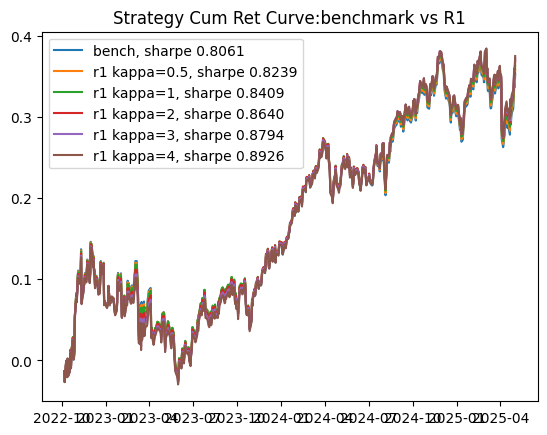

In [ ]:
model_name = 'benchmark vs R1'
sharpe_b = format(sharpe(ret_benchmark['no param']), '.4f')
plt.plot(ret_benchmark['no param'].cumsum(), label=f'bench, sharpe {sharpe_b}')

for k in kappas:
  sharpe_ = format(sharpe(ret_r1[k]), '.4f')
  plt.plot(ret_r1[k].cumsum(), label = f'r1 kappa={k}, sharpe {sharpe_}')

plt.title(f'Strategy Cum Ret Curve:{model_name}')
plt.legend()

In [ ]:
win_rates_r1 = [format(win_rate(error_benchmark['no param'], error_r1[k]), '.2%') for k in kappas]
print(model_name)
win_rate_df_r1= pd.DataFrame({'kappa':kappas, 'win_rates':win_rates_r1})
print(win_rate_df_r1)

benchmark vs R1
   kappa win_rates
0    0.5    56.43%
1    1.0    57.21%
2    2.0    57.67%
3    3.0    58.29%
4    4.0    58.29%


## Comparison 1.2 across benchmark & robust model 2: Using equal time decay function and explore different kappas

In [ ]:
#ata = sector_data['Information Technology']
# kappas = [0.25, 0.5, 0.75, 1, 1.5, 2, 3]
kappas = [0.5, 1, 2, 3, 4]
ret_r2, error_r2 = rolling_backtest(data, equal_decay, robust_opt_two, kappas)

iterating hyper parameters:   0%|          | 0/5 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

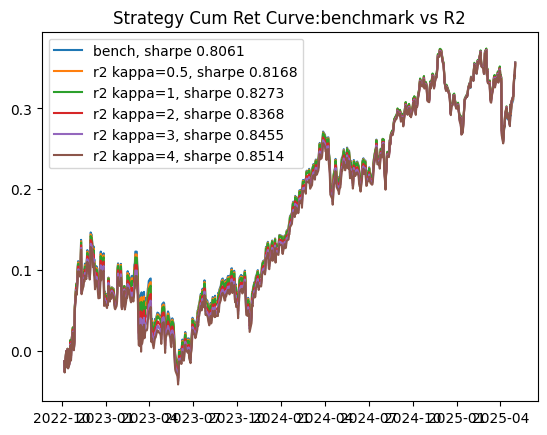

In [ ]:
model_name = 'benchmark vs R2'
sharpe_b = format(sharpe(ret_benchmark['no param']), '.4f')
plt.plot(ret_benchmark['no param'].cumsum(), label=f'bench, sharpe {sharpe_b}')

for k in kappas:
  sharpe_ = format(sharpe(ret_r2[k]), '.4f')
  plt.plot(ret_r2[k].cumsum(), label = f'r2 kappa={k}, sharpe {sharpe_}')

plt.title(f'Strategy Cum Ret Curve:{model_name}')
plt.legend()

In [ ]:
win_rates_r2 = [format(win_rate(error_benchmark['no param'], error_r2[k]), '.2%') for k in kappas]
print(model_name)
win_rate_df_r2= pd.DataFrame({'kappa':kappas, 'win_rates':win_rates_r2})
print(win_rate_df_r2)

benchmark vs R2
   kappa win_rates
0    0.5    57.36%
1    1.0    56.90%
2    2.0    56.12%
3    3.0    55.81%
4    4.0    57.36%


## Comparison 1.3 across benchmark & robust model 3: Using equal time decay function and explore different kappas

In [ ]:
#data = sector_data['Information Technology']
# kappas = [0.25, 0.5, 0.75, 1, 1.5, 2, 3]
kappas = [0.5, 1, 2,3,4]
ret_r3, error_r3 = rolling_backtest(data, equal_decay, robust_opt_three, kappas)

iterating hyper parameters:   0%|          | 0/5 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

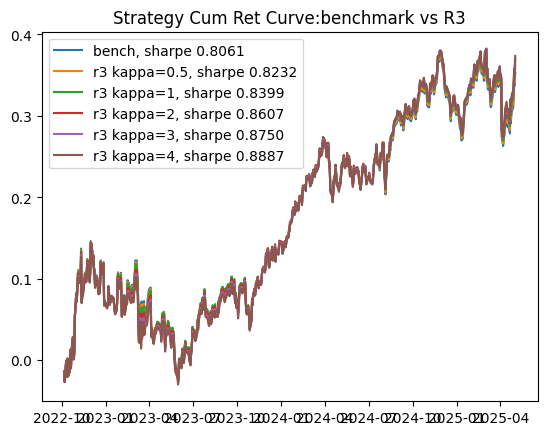

In [ ]:
model_name = 'benchmark vs R3'
sharpe_b = format(sharpe(ret_benchmark['no param']), '.4f')
plt.plot(ret_benchmark['no param'].cumsum(), label=f'bench, sharpe {sharpe_b}')

for k in kappas:
  sharpe_ = format(sharpe(ret_r3[k]), '.4f')
  plt.plot(ret_r3[k].cumsum(), label = f'r3 kappa={k}, sharpe {sharpe_}')

plt.title(f'Strategy Cum Ret Curve:{model_name}')
plt.legend()

In [ ]:
win_rates_r3 = [format(win_rate(error_benchmark['no param'], error_r3[k]), '.2%') for k in kappas]
print(model_name)
win_rate_df_r3= pd.DataFrame({'kappa':kappas, 'win_rates':win_rates_r3})
print(win_rate_df_r3)

benchmark vs R3
   kappa win_rates
0    0.5    57.83%
1    1.0    57.67%
2    2.0    59.69%
3    3.0    60.47%
4    4.0    60.62%


## Comparison 2.1: across benchmarks: using different Time Decay Functions

In [ ]:
#data = sector_data['Information Technology']
ret_benchmark_lin, error_benchmark_lin = rolling_backtest(data, linear_decay, benchmark, ['no param'])

iterating hyper parameters:   0%|          | 0/1 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

In [ ]:
#data = sector_data['Information Technology']
# kappas = [0.25, 0.5, 0.75, 1, 1.5, 2, 3]
kappas = [0.5, 1, 2, 3, 4]
ret_r1_lin, error_r1_lin = rolling_backtest(data, linear_decay, robust_opt_one, kappas)

iterating hyper parameters:   0%|          | 0/5 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

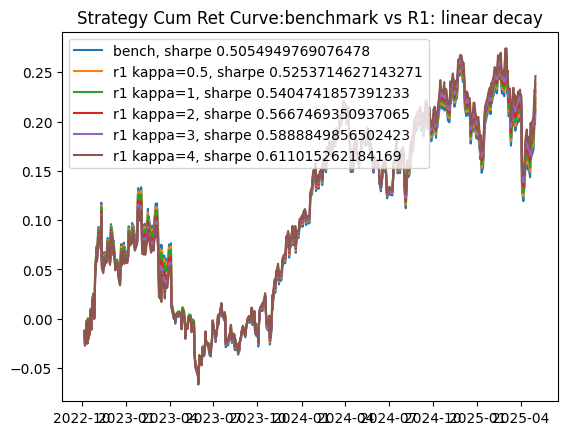

In [ ]:
model_name = 'benchmark vs R1: linear decay'
sharpe_b = sharpe(ret_benchmark_lin['no param'])
plt.plot(ret_benchmark_lin['no param'].cumsum(), label=f'bench, sharpe {sharpe_b}')

for k in kappas:
  sharpe_ = sharpe(ret_r1_lin[k])
  plt.plot(ret_r1_lin[k].cumsum(), label = f'r1 kappa={k}, sharpe {sharpe_}')

plt.title(f'Strategy Cum Ret Curve:{model_name}')
plt.legend()

In [ ]:
win_rates_r1_lin = [format(win_rate(error_benchmark_lin['no param'], error_r1_lin[k]), '.2%') for k in kappas]
print(model_name)
win_rate_df_r1_lin= pd.DataFrame({'kappa':kappas, 'win_rates':win_rates_r1_lin})
print(win_rate_df_r1_lin)

benchmark vs R1: linear decay
   kappa win_rates
0    0.5    58.29%
1    1.0    58.14%
2    2.0    58.14%
3    3.0    57.83%
4    4.0    57.83%


In [ ]:
#data = sector_data['Information Technology']
# kappas = [0.25, 0.5, 0.75, 1, 1.5, 2, 3]
kappas = [0.5, 1, 2, 3, 4]
ret_r2_lin, error_r2_lin = rolling_backtest(data, linear_decay, robust_opt_two, kappas)

iterating hyper parameters:   0%|          | 0/5 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

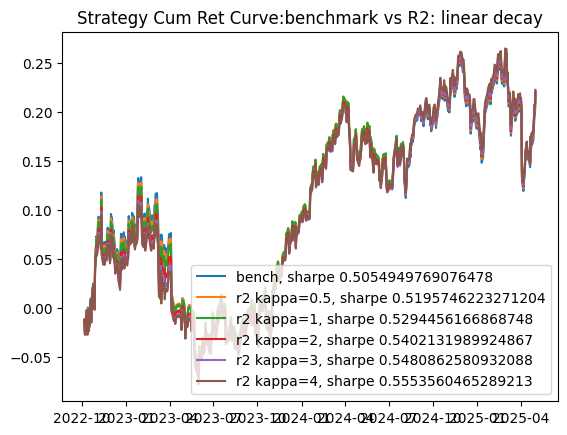

In [ ]:
model_name = 'benchmark vs R2: linear decay'
sharpe_b = sharpe(ret_benchmark_lin['no param'])
plt.plot(ret_benchmark_lin['no param'].cumsum(), label=f'bench, sharpe {sharpe_b}')

for k in kappas:
  sharpe_ = sharpe(ret_r2_lin[k])
  plt.plot(ret_r2_lin[k].cumsum(), label = f'r2 kappa={k}, sharpe {sharpe_}')

plt.title(f'Strategy Cum Ret Curve:{model_name}')
plt.legend()

In [ ]:
win_rates_r2_lin = [format(win_rate(error_benchmark_lin['no param'], error_r2_lin[k]), '.2%') for k in kappas]
print(model_name)
win_rate_df_r2_lin= pd.DataFrame({'kappa':kappas, 'win_rates':win_rates_r2_lin})
print(win_rate_df_r2_lin)

benchmark vs R2: linear decay
   kappa win_rates
0    0.5    57.05%
1    1.0    56.12%
2    2.0    55.97%
3    3.0    54.73%
4    4.0    54.88%


In [ ]:
#data = sector_data['Information Technology']
# kappas = [0.25, 0.5, 0.75, 1, 1.5, 2, 3]
kappas = [0.5, 1, 2, 3, 4]
ret_r3_lin, error_r3_lin = rolling_backtest(data, linear_decay, robust_opt_three, kappas)

iterating hyper parameters:   0%|          | 0/5 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

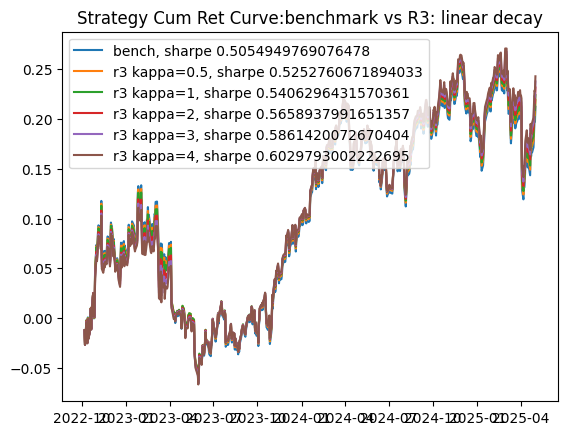

In [ ]:
model_name = 'benchmark vs R3: linear decay'
sharpe_b = sharpe(ret_benchmark_lin['no param'])
plt.plot(ret_benchmark_lin['no param'].cumsum(), label=f'bench, sharpe {sharpe_b}')

for k in kappas:
  sharpe_ = sharpe(ret_r3_lin[k])
  plt.plot(ret_r3_lin[k].cumsum(), label = f'r3 kappa={k}, sharpe {sharpe_}')

plt.title(f'Strategy Cum Ret Curve:{model_name}')
plt.legend()

In [ ]:
win_rates_r3_lin = [format(win_rate(error_benchmark_lin['no param'], error_r3_lin[k]), '.2%') for k in kappas]
print(model_name)
win_rate_df_r3_lin= pd.DataFrame({'kappa':kappas, 'win_rates':win_rates_r3_lin})
print(win_rate_df_r3_lin)

benchmark vs R3: linear decay
   kappa win_rates
0    0.5    57.05%
1    1.0    57.67%
2    2.0    58.29%
3    3.0    58.45%
4    4.0    57.98%


## Comparison 2.2 across robust model 1: using different Time Decay Functions

In [ ]:
#data = sector_data['Information Technology']
ret_benchmark_sqrt, error_benchmark_sqrt = rolling_backtest(data, sqrt_decay, benchmark, ['no param'])

iterating hyper parameters:   0%|          | 0/1 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

In [ ]:
#data = sector_data['Information Technology']
# kappas = [0.25, 0.5, 0.75, 1, 1.5, 2, 3]
kappas = [0.5, 1, 2, 3, 4]
ret_r1_sqrt, error_r1_sqrt = rolling_backtest(data, sqrt_decay, robust_opt_one, kappas)

iterating hyper parameters:   0%|          | 0/5 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

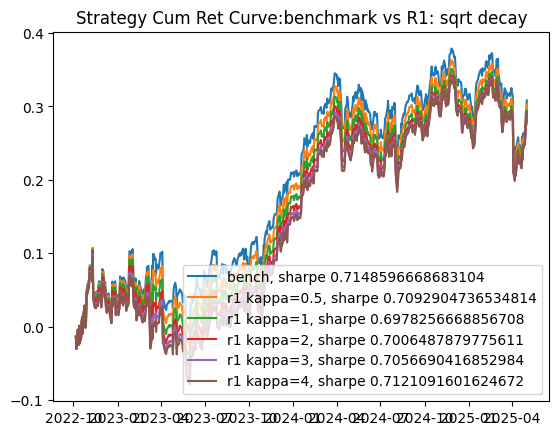

In [ ]:
model_name = 'benchmark vs R1: sqrt decay'
sharpe_b = sharpe(ret_benchmark_sqrt['no param'])
plt.plot(ret_benchmark_sqrt['no param'].cumsum(), label=f'bench, sharpe {sharpe_b}')

for k in kappas:
  sharpe_ = sharpe(ret_r1_sqrt[k])
  plt.plot(ret_r1_sqrt[k].cumsum(), label = f'r1 kappa={k}, sharpe {sharpe_}')

plt.title(f'Strategy Cum Ret Curve:{model_name}')
plt.legend()

In [ ]:
win_rates_r1_sqrt = [format(win_rate(error_benchmark_sqrt['no param'], error_r1_sqrt[k]), '.2%') for k in kappas]
print(model_name)
win_rate_df_r1_sqrt= pd.DataFrame({'kappa':kappas, 'win_rates':win_rates_r1_sqrt})
print(win_rate_df_r1_sqrt)

benchmark vs R1: sqrt decay
   kappa win_rates
0    0.5    56.74%
1    1.0    55.81%
2    2.0    56.28%
3    3.0    56.90%
4    4.0    57.83%


In [ ]:
# data = sector_data['Information Technology']
# kappas = [0.25, 0.5, 0.75, 1, 1.5, 2, 3]
kappas = [0.5, 1, 2, 3, 4]
ret_r2_sqrt, error_r2_sqrt = rolling_backtest(data, sqrt_decay, robust_opt_two, kappas)

iterating hyper parameters:   0%|          | 0/5 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

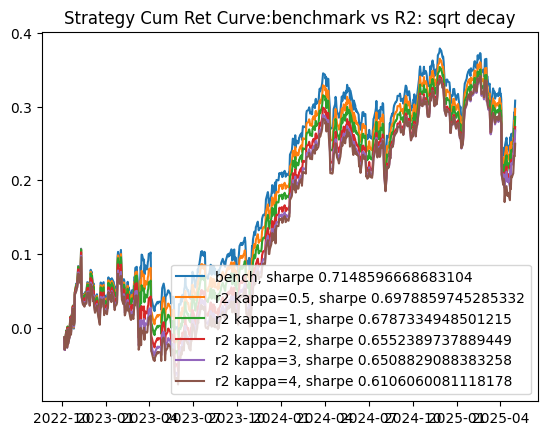

In [ ]:
model_name = 'benchmark vs R2: sqrt decay'
sharpe_b = sharpe(ret_benchmark_sqrt['no param'])
plt.plot(ret_benchmark_sqrt['no param'].cumsum(), label=f'bench, sharpe {sharpe_b}')

for k in kappas:
  sharpe_ = sharpe(ret_r2_sqrt[k])
  plt.plot(ret_r2_sqrt[k].cumsum(), label = f'r2 kappa={k}, sharpe {sharpe_}')

plt.title(f'Strategy Cum Ret Curve:{model_name}')
plt.legend()

In [ ]:
win_rates_r2_sqrt = [format(win_rate(error_benchmark_sqrt['no param'], error_r2_sqrt[k]), '.2%') for k in kappas]
print(model_name)
win_rate_df_r2_sqrt= pd.DataFrame({'kappa':kappas, 'win_rates':win_rates_r2_sqrt})
print(win_rate_df_r2_sqrt)

benchmark vs R2: sqrt decay
   kappa win_rates
0    0.5    55.66%
1    1.0    55.35%
2    2.0    55.19%
3    3.0    54.73%
4    4.0    54.11%


In [ ]:
#data = sector_data['Information Technology']
# kappas = [0.25, 0.5, 0.75, 1, 1.5, 2, 3]
kappas = [0.5, 1, 2, 3, 4]
ret_r3_sqrt, error_r3_sqrt = rolling_backtest(data, sqrt_decay, robust_opt_three, kappas)

iterating hyper parameters:   0%|          | 0/5 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

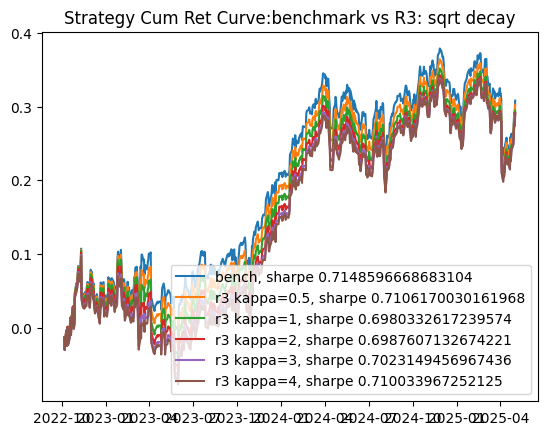

In [ ]:
model_name = 'benchmark vs R3: sqrt decay'
sharpe_b = sharpe(ret_benchmark_sqrt['no param'])
plt.plot(ret_benchmark_sqrt['no param'].cumsum(), label=f'bench, sharpe {sharpe_b}')

for k in kappas:
  sharpe_ = sharpe(ret_r3_sqrt[k])
  plt.plot(ret_r3_sqrt[k].cumsum(), label = f'r3 kappa={k}, sharpe {sharpe_}')

plt.title(f'Strategy Cum Ret Curve:{model_name}')
plt.legend()

In [ ]:
win_rates_r3_sqrt = [format(win_rate(error_benchmark_sqrt['no param'], error_r3_sqrt[k]), '.2%') for k in kappas]
print(model_name)
win_rate_df_r3_sqrt= pd.DataFrame({'kappa':kappas, 'win_rates':win_rates_r3_sqrt})
print(win_rate_df_r3_sqrt)

benchmark vs R3: sqrt decay
   kappa win_rates
0    0.5    57.98%
1    1.0    56.74%
2    2.0    57.52%
3    3.0    57.52%
4    4.0    57.67%


## Comparison 2.3 across robust model 3: using different time decay functions

In [ ]:
#data = sector_data['Information Technology']
data = sector_data['Financials']
ret_benchmark_exp, error_benchmark_exp = rolling_backtest(data, exponential_decay, benchmark, ['no param'])

iterating hyper parameters:   0%|          | 0/1 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
 0.43604929 0.44043165 0.44485807 0.44932896 0.4538448  0.45840601
 0.46301307 0.46766643 0.47236655 0.47711392 0.48190899 0.48675226
 0.4916442  0.4965853  0.50157607 0.50661699 0.51170858 0.51685133
 0.52204578 0.52729242 0.5325918  0.53794444 0.54335087 0.54881164
 0.55432728 0.55989837 0.56552544 0.57120906 0.57694981 0.58274825
 0.58860497 0.59452055 0.60049558 0.60653066 0.61262639 0.61878339
 0.62500227 0.63128365 0.63762815 0.64403642 0.65050909 0.65704682
 0.66365025 0.67032005 0.67705687 0.68386141 0.69073433 0.69767633
 0.70468809 0.71177032 0.71892373 0.72614904 0.73344696 0.74081822
 0.74826357 0.75578374 0.76337949 0.77105159 0.77880078 0.78662786
 0.7945336  0.8025188  0.81058425 0.81873075 0.82695913 0.83527021
 0.84366482 0.85214379 0.86070798 0.86935824 0.87809543 0.88692044
 0.89583414 0.90483742 0.91393119 0.92311635 0.93239382 0.94176453
 0.95122942 0.96078944 0.97044553 0.98019867 0.99004983 1.        ]
[0.3430085

In [ ]:
#data = sector_data['Information Technology']
# kappas = [0.25, 0.5, 0.75, 1, 1.5, 2, 3]
kappas = [0.5, 1, 2, 3, 4]
ret_r1_exp, error_r1_exp = rolling_backtest(data, exponential_decay, robust_opt_one, kappas)

iterating hyper parameters:   0%|          | 0/5 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
 0.43604929 0.44043165 0.44485807 0.44932896 0.4538448  0.45840601
 0.46301307 0.46766643 0.47236655 0.47711392 0.48190899 0.48675226
 0.4916442  0.4965853  0.50157607 0.50661699 0.51170858 0.51685133
 0.52204578 0.52729242 0.5325918  0.53794444 0.54335087 0.54881164
 0.55432728 0.55989837 0.56552544 0.57120906 0.57694981 0.58274825
 0.58860497 0.59452055 0.60049558 0.60653066 0.61262639 0.61878339
 0.62500227 0.63128365 0.63762815 0.64403642 0.65050909 0.65704682
 0.66365025 0.67032005 0.67705687 0.68386141 0.69073433 0.69767633
 0.70468809 0.71177032 0.71892373 0.72614904 0.73344696 0.74081822
 0.74826357 0.75578374 0.76337949 0.77105159 0.77880078 0.78662786
 0.7945336  0.8025188  0.81058425 0.81873075 0.82695913 0.83527021
 0.84366482 0.85214379 0.86070798 0.86935824 0.87809543 0.88692044
 0.89583414 0.90483742 0.91393119 0.92311635 0.93239382 0.94176453
 0.95122942 0.96078944 0.97044553 0.98019867 0.99004983 1.        ]
[0.3430085

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
 0.43604929 0.44043165 0.44485807 0.44932896 0.4538448  0.45840601
 0.46301307 0.46766643 0.47236655 0.47711392 0.48190899 0.48675226
 0.4916442  0.4965853  0.50157607 0.50661699 0.51170858 0.51685133
 0.52204578 0.52729242 0.5325918  0.53794444 0.54335087 0.54881164
 0.55432728 0.55989837 0.56552544 0.57120906 0.57694981 0.58274825
 0.58860497 0.59452055 0.60049558 0.60653066 0.61262639 0.61878339
 0.62500227 0.63128365 0.63762815 0.64403642 0.65050909 0.65704682
 0.66365025 0.67032005 0.67705687 0.68386141 0.69073433 0.69767633
 0.70468809 0.71177032 0.71892373 0.72614904 0.73344696 0.74081822
 0.74826357 0.75578374 0.76337949 0.77105159 0.77880078 0.78662786
 0.7945336  0.8025188  0.81058425 0.81873075 0.82695913 0.83527021
 0.84366482 0.85214379 0.86070798 0.86935824 0.87809543 0.88692044
 0.89583414 0.90483742 0.91393119 0.92311635 0.93239382 0.94176453
 0.95122942 0.96078944 0.97044553 0.98019867 0.99004983 1.        ]
[0.3430085

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
 0.43604929 0.44043165 0.44485807 0.44932896 0.4538448  0.45840601
 0.46301307 0.46766643 0.47236655 0.47711392 0.48190899 0.48675226
 0.4916442  0.4965853  0.50157607 0.50661699 0.51170858 0.51685133
 0.52204578 0.52729242 0.5325918  0.53794444 0.54335087 0.54881164
 0.55432728 0.55989837 0.56552544 0.57120906 0.57694981 0.58274825
 0.58860497 0.59452055 0.60049558 0.60653066 0.61262639 0.61878339
 0.62500227 0.63128365 0.63762815 0.64403642 0.65050909 0.65704682
 0.66365025 0.67032005 0.67705687 0.68386141 0.69073433 0.69767633
 0.70468809 0.71177032 0.71892373 0.72614904 0.73344696 0.74081822
 0.74826357 0.75578374 0.76337949 0.77105159 0.77880078 0.78662786
 0.7945336  0.8025188  0.81058425 0.81873075 0.82695913 0.83527021
 0.84366482 0.85214379 0.86070798 0.86935824 0.87809543 0.88692044
 0.89583414 0.90483742 0.91393119 0.92311635 0.93239382 0.94176453
 0.95122942 0.96078944 0.97044553 0.98019867 0.99004983 1.        ]
[0.3430085

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
 0.43604929 0.44043165 0.44485807 0.44932896 0.4538448  0.45840601
 0.46301307 0.46766643 0.47236655 0.47711392 0.48190899 0.48675226
 0.4916442  0.4965853  0.50157607 0.50661699 0.51170858 0.51685133
 0.52204578 0.52729242 0.5325918  0.53794444 0.54335087 0.54881164
 0.55432728 0.55989837 0.56552544 0.57120906 0.57694981 0.58274825
 0.58860497 0.59452055 0.60049558 0.60653066 0.61262639 0.61878339
 0.62500227 0.63128365 0.63762815 0.64403642 0.65050909 0.65704682
 0.66365025 0.67032005 0.67705687 0.68386141 0.69073433 0.69767633
 0.70468809 0.71177032 0.71892373 0.72614904 0.73344696 0.74081822
 0.74826357 0.75578374 0.76337949 0.77105159 0.77880078 0.78662786
 0.7945336  0.8025188  0.81058425 0.81873075 0.82695913 0.83527021
 0.84366482 0.85214379 0.86070798 0.86935824 0.87809543 0.88692044
 0.89583414 0.90483742 0.91393119 0.92311635 0.93239382 0.94176453
 0.95122942 0.96078944 0.97044553 0.98019867 0.99004983 1.        ]
[0.3430085

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
 0.43604929 0.44043165 0.44485807 0.44932896 0.4538448  0.45840601
 0.46301307 0.46766643 0.47236655 0.47711392 0.48190899 0.48675226
 0.4916442  0.4965853  0.50157607 0.50661699 0.51170858 0.51685133
 0.52204578 0.52729242 0.5325918  0.53794444 0.54335087 0.54881164
 0.55432728 0.55989837 0.56552544 0.57120906 0.57694981 0.58274825
 0.58860497 0.59452055 0.60049558 0.60653066 0.61262639 0.61878339
 0.62500227 0.63128365 0.63762815 0.64403642 0.65050909 0.65704682
 0.66365025 0.67032005 0.67705687 0.68386141 0.69073433 0.69767633
 0.70468809 0.71177032 0.71892373 0.72614904 0.73344696 0.74081822
 0.74826357 0.75578374 0.76337949 0.77105159 0.77880078 0.78662786
 0.7945336  0.8025188  0.81058425 0.81873075 0.82695913 0.83527021
 0.84366482 0.85214379 0.86070798 0.86935824 0.87809543 0.88692044
 0.89583414 0.90483742 0.91393119 0.92311635 0.93239382 0.94176453
 0.95122942 0.96078944 0.97044553 0.98019867 0.99004983 1.        ]
[0.3430085

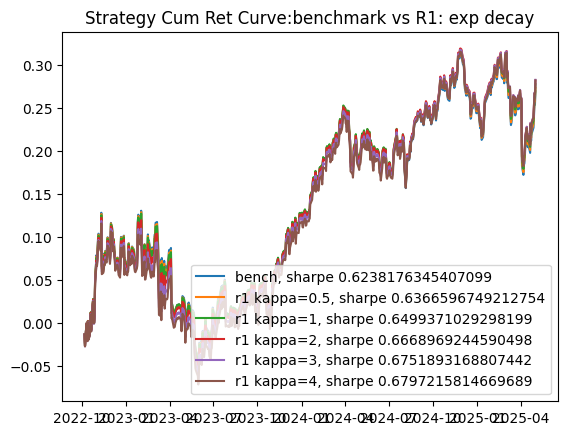

In [ ]:
model_name = 'benchmark vs R1: exp decay'
sharpe_b = sharpe(ret_benchmark_exp['no param'])
plt.plot(ret_benchmark_exp['no param'].cumsum(), label=f'bench, sharpe {sharpe_b}')

for k in kappas:
  sharpe_ = sharpe(ret_r1_exp[k])
  plt.plot(ret_r1_exp[k].cumsum(), label = f'r1 kappa={k}, sharpe {sharpe_}')

plt.title(f'Strategy Cum Ret Curve:{model_name}')
plt.legend()

In [ ]:
win_rates_r1_exp = [format(win_rate(error_benchmark_exp['no param'], error_r1_exp[k]), '.2%') for k in kappas]
print(model_name)
win_rate_df_r1_exp= pd.DataFrame({'kappa':kappas, 'win_rates':win_rates_r1_exp})
print(win_rate_df_r1_exp)

benchmark vs R1: exp decay
   kappa win_rates
0    0.5    56.74%
1    1.0    56.74%
2    2.0    57.05%
3    3.0    57.36%
4    4.0    57.52%


In [ ]:
#data = sector_data['Information Technology']
# kappas = [0.25, 0.5, 0.75, 1, 1.5, 2, 3]
kappas = [0.5, 1, 2, 3, 4]
ret_r2_exp, error_r2_exp = rolling_backtest(data, exponential_decay, robust_opt_two, kappas)

iterating hyper parameters:   0%|          | 0/5 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
 0.43604929 0.44043165 0.44485807 0.44932896 0.4538448  0.45840601
 0.46301307 0.46766643 0.47236655 0.47711392 0.48190899 0.48675226
 0.4916442  0.4965853  0.50157607 0.50661699 0.51170858 0.51685133
 0.52204578 0.52729242 0.5325918  0.53794444 0.54335087 0.54881164
 0.55432728 0.55989837 0.56552544 0.57120906 0.57694981 0.58274825
 0.58860497 0.59452055 0.60049558 0.60653066 0.61262639 0.61878339
 0.62500227 0.63128365 0.63762815 0.64403642 0.65050909 0.65704682
 0.66365025 0.67032005 0.67705687 0.68386141 0.69073433 0.69767633
 0.70468809 0.71177032 0.71892373 0.72614904 0.73344696 0.74081822
 0.74826357 0.75578374 0.76337949 0.77105159 0.77880078 0.78662786
 0.7945336  0.8025188  0.81058425 0.81873075 0.82695913 0.83527021
 0.84366482 0.85214379 0.86070798 0.86935824 0.87809543 0.88692044
 0.89583414 0.90483742 0.91393119 0.92311635 0.93239382 0.94176453
 0.95122942 0.96078944 0.97044553 0.98019867 0.99004983 1.        ]
[0.3430085

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
 0.43604929 0.44043165 0.44485807 0.44932896 0.4538448  0.45840601
 0.46301307 0.46766643 0.47236655 0.47711392 0.48190899 0.48675226
 0.4916442  0.4965853  0.50157607 0.50661699 0.51170858 0.51685133
 0.52204578 0.52729242 0.5325918  0.53794444 0.54335087 0.54881164
 0.55432728 0.55989837 0.56552544 0.57120906 0.57694981 0.58274825
 0.58860497 0.59452055 0.60049558 0.60653066 0.61262639 0.61878339
 0.62500227 0.63128365 0.63762815 0.64403642 0.65050909 0.65704682
 0.66365025 0.67032005 0.67705687 0.68386141 0.69073433 0.69767633
 0.70468809 0.71177032 0.71892373 0.72614904 0.73344696 0.74081822
 0.74826357 0.75578374 0.76337949 0.77105159 0.77880078 0.78662786
 0.7945336  0.8025188  0.81058425 0.81873075 0.82695913 0.83527021
 0.84366482 0.85214379 0.86070798 0.86935824 0.87809543 0.88692044
 0.89583414 0.90483742 0.91393119 0.92311635 0.93239382 0.94176453
 0.95122942 0.96078944 0.97044553 0.98019867 0.99004983 1.        ]
[0.3430085

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
 0.43604929 0.44043165 0.44485807 0.44932896 0.4538448  0.45840601
 0.46301307 0.46766643 0.47236655 0.47711392 0.48190899 0.48675226
 0.4916442  0.4965853  0.50157607 0.50661699 0.51170858 0.51685133
 0.52204578 0.52729242 0.5325918  0.53794444 0.54335087 0.54881164
 0.55432728 0.55989837 0.56552544 0.57120906 0.57694981 0.58274825
 0.58860497 0.59452055 0.60049558 0.60653066 0.61262639 0.61878339
 0.62500227 0.63128365 0.63762815 0.64403642 0.65050909 0.65704682
 0.66365025 0.67032005 0.67705687 0.68386141 0.69073433 0.69767633
 0.70468809 0.71177032 0.71892373 0.72614904 0.73344696 0.74081822
 0.74826357 0.75578374 0.76337949 0.77105159 0.77880078 0.78662786
 0.7945336  0.8025188  0.81058425 0.81873075 0.82695913 0.83527021
 0.84366482 0.85214379 0.86070798 0.86935824 0.87809543 0.88692044
 0.89583414 0.90483742 0.91393119 0.92311635 0.93239382 0.94176453
 0.95122942 0.96078944 0.97044553 0.98019867 0.99004983 1.        ]
[0.3430085

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
 0.43604929 0.44043165 0.44485807 0.44932896 0.4538448  0.45840601
 0.46301307 0.46766643 0.47236655 0.47711392 0.48190899 0.48675226
 0.4916442  0.4965853  0.50157607 0.50661699 0.51170858 0.51685133
 0.52204578 0.52729242 0.5325918  0.53794444 0.54335087 0.54881164
 0.55432728 0.55989837 0.56552544 0.57120906 0.57694981 0.58274825
 0.58860497 0.59452055 0.60049558 0.60653066 0.61262639 0.61878339
 0.62500227 0.63128365 0.63762815 0.64403642 0.65050909 0.65704682
 0.66365025 0.67032005 0.67705687 0.68386141 0.69073433 0.69767633
 0.70468809 0.71177032 0.71892373 0.72614904 0.73344696 0.74081822
 0.74826357 0.75578374 0.76337949 0.77105159 0.77880078 0.78662786
 0.7945336  0.8025188  0.81058425 0.81873075 0.82695913 0.83527021
 0.84366482 0.85214379 0.86070798 0.86935824 0.87809543 0.88692044
 0.89583414 0.90483742 0.91393119 0.92311635 0.93239382 0.94176453
 0.95122942 0.96078944 0.97044553 0.98019867 0.99004983 1.        ]
[0.3430085

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
 0.43604929 0.44043165 0.44485807 0.44932896 0.4538448  0.45840601
 0.46301307 0.46766643 0.47236655 0.47711392 0.48190899 0.48675226
 0.4916442  0.4965853  0.50157607 0.50661699 0.51170858 0.51685133
 0.52204578 0.52729242 0.5325918  0.53794444 0.54335087 0.54881164
 0.55432728 0.55989837 0.56552544 0.57120906 0.57694981 0.58274825
 0.58860497 0.59452055 0.60049558 0.60653066 0.61262639 0.61878339
 0.62500227 0.63128365 0.63762815 0.64403642 0.65050909 0.65704682
 0.66365025 0.67032005 0.67705687 0.68386141 0.69073433 0.69767633
 0.70468809 0.71177032 0.71892373 0.72614904 0.73344696 0.74081822
 0.74826357 0.75578374 0.76337949 0.77105159 0.77880078 0.78662786
 0.7945336  0.8025188  0.81058425 0.81873075 0.82695913 0.83527021
 0.84366482 0.85214379 0.86070798 0.86935824 0.87809543 0.88692044
 0.89583414 0.90483742 0.91393119 0.92311635 0.93239382 0.94176453
 0.95122942 0.96078944 0.97044553 0.98019867 0.99004983 1.        ]
[0.3430085

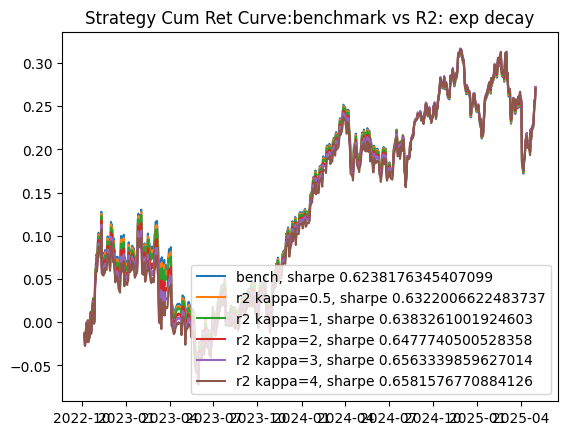

In [ ]:
model_name = 'benchmark vs R2: exp decay'
sharpe_b = sharpe(ret_benchmark_exp['no param'])
plt.plot(ret_benchmark_exp['no param'].cumsum(), label=f'bench, sharpe {sharpe_b}')

for k in kappas:
  sharpe_ = sharpe(ret_r2_exp[k])
  plt.plot(ret_r2_exp[k].cumsum(), label = f'r2 kappa={k}, sharpe {sharpe_}')

plt.title(f'Strategy Cum Ret Curve:{model_name}')
plt.legend()

In [ ]:
win_rates_r2_exp = [format(win_rate(error_benchmark_exp['no param'], error_r2_exp[k]), '.2%') for k in kappas]
print(model_name)
win_rate_df_r2_exp= pd.DataFrame({'kappa':kappas, 'win_rates':win_rates_r2_exp})
print(win_rate_df_r2_exp)

benchmark vs R2: exp decay
   kappa win_rates
0    0.5    53.80%
1    1.0    54.57%
2    2.0    54.88%
3    3.0    54.26%
4    4.0    55.35%


In [ ]:
#data = sector_data['Information Technology']
# kappas = [0.25, 0.5, 0.75, 1, 1.5, 2, 3]
kappas = [0.5, 1, 2, 3, 4]
ret_r3_exp, error_r3_exp = rolling_backtest(data, exponential_decay, robust_opt_three, kappas)

iterating hyper parameters:   0%|          | 0/5 [00:00<?, ?it/s]

iterating dates:   0%|          | 0/645 [00:00<?, ?it/s]

[0.34300852 0.34645581 0.34993775 0.35345468 0.35700696 0.36059494
 0.36421898 0.36787944 0.37157669 0.3753111  0.37908304 0.38289289
 0.38674102 0.39062784 0.39455371 0.39851904 0.40252422 0.40656966
 0.41065575 0.41478291 0.41895155 0.42316208 0.42741493 0.43171052
 0.43604929 0.44043165 0.44485807 0.44932896 0.4538448  0.45840601
 0.46301307 0.46766643 0.47236655 0.47711392 0.48190899 0.48675226
 0.4916442  0.4965853  0.50157607 0.50661699 0.51170858 0.51685133
 0.52204578 0.52729242 0.5325918  0.53794444 0.54335087 0.54881164
 0.55432728 0.55989837 0.56552544 0.57120906 0.57694981 0.58274825
 0.58860497 0.59452055 0.60049558 0.60653066 0.61262639 0.61878339
 0.62500227 0.63128365 0.63762815 0.64403642 0.65050909 0.65704682
 0.66365025 0.67032005 0.67705687 0.68386141 0.69073433 0.69767633
 0.70468809 0.71177032 0.71892373 0.72614904 0.73344696 0.74081822
 0.74826357 0.75578374 0.76337949 0.77105159 0.77880078 0.78662786
 0.7945336  0.8025188  0.81058425 0.81873075 0.82695913 0.8352

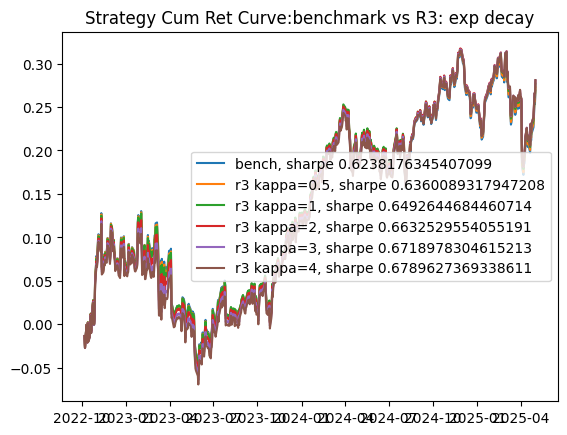

In [ ]:
model_name = 'benchmark vs R3: exp decay'
sharpe_b = sharpe(ret_benchmark_exp['no param'])
plt.plot(ret_benchmark_exp['no param'].cumsum(), label=f'bench, sharpe {sharpe_b}')

for k in kappas:
  sharpe_ = sharpe(ret_r3_exp[k])
  plt.plot(ret_r3_exp[k].cumsum(), label = f'r3 kappa={k}, sharpe {sharpe_}')

plt.title(f'Strategy Cum Ret Curve:{model_name}')
plt.legend()

In [ ]:
win_rates_r3_exp = [format(win_rate(error_benchmark_exp['no param'], error_r3_exp[k]), '.2%') for k in kappas]
print(model_name)
win_rate_df_r3_exp= pd.DataFrame({'kappa':kappas, 'win_rates':win_rates_r3_exp})
print(win_rate_df_r3_exp)

benchmark vs R3: exp decay
   kappa win_rates
0    0.5    54.73%
1    1.0    55.97%
2    2.0    57.52%
3    3.0    56.74%
4    4.0    56.43%


In [ ]:
res_dfs = [win_rate_df_r1, win_rate_df_r1_exp, win_rate_df_r1_lin, win_rate_df_r1_sqrt, win_rate_df_r2, win_rate_df_r2_exp, win_rate_df_r2_lin, win_rate_df_r2_sqrt, win_rate_df_r3, win_rate_df_r3_exp, win_rate_df_r2_lin, win_rate_df_r3_sqrt]

res_df_ = pd.concat(res_dfs, axis=0)

optimizer = ['r1']*20 + ['r2']*20 + ['r3']*20
decay_funcs = (['simple']*5 + ['exp']*5 + ['lin']*5 + ['sqrt']*5)*3

res_df_.insert(0, 'optimizer', optimizer)
res_df_.insert(1, 'decay_funcs', decay_funcs)

res_df_

optimizer decay_funcs  kappa win_rates
0        r1      simple    0.5    56.43%
1        r1      simple    1.0    57.21%
2        r1      simple    2.0    57.67%
3        r1      simple    3.0    58.29%
4        r1      simple    4.0    58.29%
0        r1         exp    0.5    56.74%
1        r1         exp    1.0    56.74%
2        r1         exp    2.0    57.05%
3        r1         exp    3.0    57.36%
4        r1         exp    4.0    57.52%
0        r1         lin    0.5    58.29%
1        r1         lin    1.0    58.14%
2        r1         lin    2.0    58.14%
3        r1         lin    3.0    57.83%
4        r1         lin    4.0    57.83%
0        r1        sqrt    0.5    56.74%
1        r1        sqrt    1.0    55.81%
2        r1        sqrt    2.0    56.28%
3        r1        sqrt    3.0    56.90%
4        r1        sqrt    4.0    57.83%
0        r2      simple    0.5    57.36%
1        r2      simple    1.0    56.90%
2        r2      simple    2.0    56.12%
3        r2      simple    3.0    55.81%
4        r2      simple    4.0    57.36%
0        r2         exp    0.5    53.80%
1        r2         exp    1.0    54.57%
2        r2         exp    2.0    54.88%
3        r2         exp    3.0    54.26%
4        r2         exp    4.0    55.35%
0        r2         lin    0.5    57.05%
1        r2         lin    1.0    56.12%
2        r2         lin    2.0    55.97%
3        r2         lin    3.0    54.73%
4        r2         lin    4.0    54.88%
0        r2        sqrt    0.5    55.66%
1        r2        sqrt    1.0    55.35%
2        r2        sqrt    2.0    55.19%
3        r2        sqrt    3.0    54.73%
4        r2        sqrt    4.0    54.11%
0        r3      simple    0.5    57.36%
1        r3      simple    1.0    56.90%
2        r3      simple    2.0    56.12%
3        r3      simple    3.0    55.81%
4        r3      simple    4.0    57.36%
0        r3         exp    0.5    53.80%
1        r3         exp    1.0    54.57%
2        r3         exp    2.0    54.88%
3        r3         exp    3.0    54.26%
4        r3         exp    4.0    55.35%
0        r3         lin    0.5    57.05%
1        r3         lin    1.0    56.12%
2        r3         lin    2.0    55.97%
3        r3         lin    3.0    54.73%
4        r3         lin    4.0    54.88%
0        r3        sqrt    0.5    55.66%
1        r3        sqrt    1.0    55.35%
2        r3        sqrt    2.0    55.19%
3        r3        sqrt    3.0    54.73%
4        r3        sqrt    4.0    54.11%